In [13]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [119]:
class Value:
    def __init__(self, data, _children = (), _op = '', label = ""): # children is a tuple can have multiple values
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._backward = lambda: None
        self._op = _op
        self.label = label
    def __repr__(self): # without repr we will get ugly cryptic output 
        return(f"Value(data = {self.data})")
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out =  Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1 * out.grad
            other.grad += 1* out.grad
        out._backward = _backward # not _backward() beacause we just want to store the function, the function() returns none
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)

        out =  Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data* out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad 
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        def _backward():
            self.grad += other* (self.data **(other -1)) * out.grad
        out._backward = _backward
        return out
    
    def __neg__(self):
        return self*-1
    
    def __sub__(self, other):
        return self + (-other)
        
    def __rmul__(self, other): # other * self, reverse multiplication
        return self * other

    def __truediv__(self, other): #self/other
        return self*(other**-1)
    def __radd__(self, other): # other + self
        return self + other

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad = (1- t**2) * out.grad            
        out._backward = _backward
        return out
    def backward(self):
        #using topological sort to first preprocess all the nodes needed for backpropagation and then finally use ._backward() function from last
        
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)                
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()



In [ ]:
a = Value(3)
# a*2  = a.__mul__(2)
#2*a = 2.__mul__(a)
a *3
3*a
b = Value(4)
a / b

Value(data = 0.75)

In [58]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

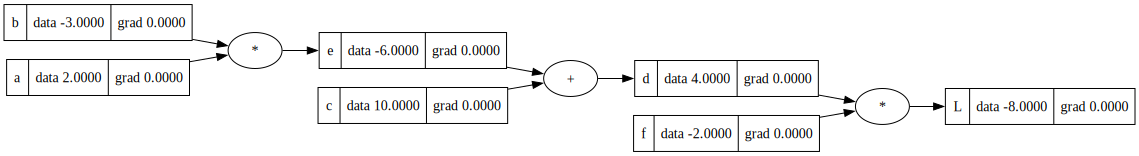

In [59]:
draw_dot(L)


In [178]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'


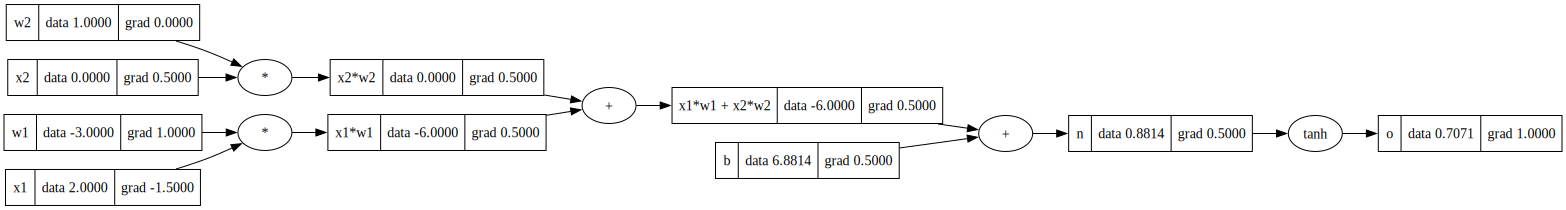

In [179]:
o.backward()
draw_dot(o)

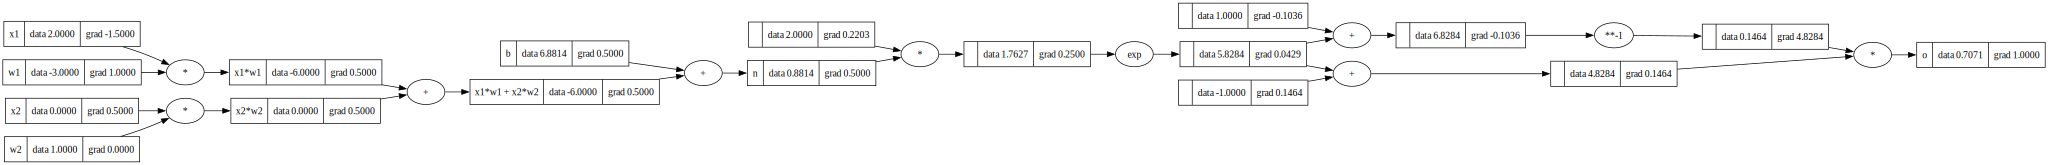

In [177]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [124]:
import random

In [189]:

class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
    def __call__(self, x):
        # w*x + b
        act = sum((wi*wx for wi, wx in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self,nin, nouts):
        sz = [nin] + nouts 
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))] 
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1.0]
n = MLP(3, [4,4,1])
n(x)


Value(data = -0.2214768735280083)

In [190]:
n.parameters()

[Value(data = 0.575050796971587),
 Value(data = -0.1012181591955652),
 Value(data = -0.44303386047208426),
 Value(data = 0.2845899338808262),
 Value(data = -0.8426755524257017),
 Value(data = 0.9611410155743116),
 Value(data = -0.49818252476446956),
 Value(data = 0.47469349537631045),
 Value(data = -0.935640365171462),
 Value(data = 0.7279453881858773),
 Value(data = 0.8373692910388557),
 Value(data = -0.3926149405200803),
 Value(data = 0.31280563070619105),
 Value(data = -0.4598626984215801),
 Value(data = -0.12932625110146123),
 Value(data = -0.03270849330859593),
 Value(data = -0.6476748383396429),
 Value(data = -0.012301975350281324),
 Value(data = -0.035354100592376314),
 Value(data = -0.9519524821237917),
 Value(data = 0.07977310077597766),
 Value(data = -0.5510181543910047),
 Value(data = -0.3439834654676024),
 Value(data = -0.7586892517243327),
 Value(data = -0.09098591524778743),
 Value(data = -0.8481207511315676),
 Value(data = 0.24759743459900174),
 Value(data = 0.9860371785

In [191]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [n(x) for x in xs ]
ypred

[Value(data = -0.2214768735280083),
 Value(data = 0.9442303315370975),
 Value(data = -0.7955956428209755),
 Value(data = 0.3679506444395363)]

In [ ]:
for k in range(20):
  
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    # backward pass
    for p in n.parameters():
        p.grad = 0.0 # we need to make sure to set grad back to zero everytime we backpropogate
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)


0 0.005120470954257143
1 0.005079019950760868
2 0.005038217383135303
3 0.004998048347593679
4 0.004958498390033471
5 0.004919553489294236
6 0.0048812000411552585
7 0.004843424843034872
8 0.004806215079356033
9 0.004769558307544579
10 0.004733442444628809
11 0.0046978557544101514
12 0.004662786835177347
13 0.00462822460793705
14 0.004594158305136087
15 0.004560577459851416
16 0.004527471895425711
17 0.004494831715527089
18 0.004462647294612732
19 0.004430909268778136


In [198]:
ypred

[Value(data = 0.9839112963171114),
 Value(data = -0.9550312307327594),
 Value(data = -0.970428928921965),
 Value(data = 0.9642869151644692)]

In [187]:
n.layers[0].neurons[1].w[0].grad

0.0

In [188]:
n.layers[0].neurons[0].w[0].data

-0.9170693528755192